In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 注意力汇聚：Nadaraya-Watson 核回归

# 1. 生成数据集

In [15]:
# 训练样本数
n_train = 50
# 排序后的训练样本
x_train, _ = torch.sort(torch.rand(n_train) * 5)

# 包含非线性成分（正弦函数）和幂函数（x^0.8）
# 生成复杂的关系，使问题不适合简单线性模型
def f(x):
    return 2 * torch.sin(x) + x**0.8

# 训练样本的输出
# 均值为0、标准差为0.5的高斯噪声
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
# 测试样本，从0到5，步长0.1，共50个点
x_test = torch.arange(0, 5, 0.1)
# 测试样本的真实输出
y_truth = f(x_test)
# 测试样本数
n_test = len(x_test)
n_test

50

In [16]:
# 可视化真实函数（y_truth）与模型预测值（y_hat）的对比
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

# 2. 平均汇聚（Baseline）

**功能** ：构建一个基线模型，所有测试点的预测值均为训练集标签的均值。

**原理** ：
`y_train.mean()`：计算训练标签的平均值（标量）。
`torch.repeat_interleave(..., n_test)`：将均值重复 `n_test` 次，生成长度为 `n_test` 的张量。

**效果** ：预测结果为一条水平直线，忽略输入数据的结构和局部模式，仅反映全局趋势。

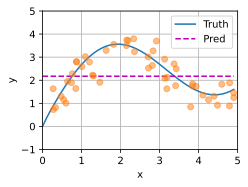

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

# 3. 非参数注意力汇聚

In [17]:
# X_repeat的形状:(n_test,n_train),
# 构造查询与键的相似度计算结构
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))


**作用** ：将每个测试输入（query）扩展为与所有训练样本（key）配对的形式。

**细节** ：
- `x_test.repeat_interleave(n_train)`：每个测试点重复 `n_train` 次。
-  `reshape((-1, n_train))`：将一维张量重塑为 `(n_test, n_train)` 矩阵，每一行是相同测试点的副本。

In [18]:
# 计算注意力权重（基于高斯核的相似度）
# `X_repeat` 是测试点的复制矩阵
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)


#### **1. 负平方欧氏距离（Negative Squared Euclidean Distance）**
- **定义**：
  对于测试点 $ x_{\text{test}}^{(i)} $ 和训练点 $ x_{\text{train}}^{(j)} $，它们的相似度计算为：
  $$
  \text{similarity}(x_{\text{test}}^{(i)}, x_{\text{train}}^{(j)}) = -\frac{(x_{\text{test}}^{(i)} - x_{\text{train}}^{(j)})^2}{2}
  $$
- 距离越近，相似度越高（越接近0）
- “平方”放大距离差异，除以2平滑数值
---

#### **2. Softmax 归一化**
- **定义**：
  将相似度转换为概率分布（权重），公式为：
$$
\alpha_{i,j} = \text{softmax}(\text{similarity}_{i,j})
= \frac{\exp(\text{similarity}_{i,j})}{\sum_{k=1}^{n_{\text{train}}} \exp(\text{similarity}_{i,k})}
$$

- 对每个测试点，所有训练点的相似度通过softmax归一化，转成“概率分布”
- 权重之和为1，且距离近的训练点权重更大
  - `dim=1` 表示按行归一化（每行对应一个测试点的所有权重）。



In [23]:
# 可视化注意力权重热力图
y_hat = torch.matmul(attention_weights, y_train)

- **功能**：通过注意力权重对训练标签进行加权平均。
- **数学形式**：
  $$
  \hat{y}(x_{\text{test}}) = \sum_{i=1}^{n_{\text{train}}} \alpha(x_{\text{test}}, x_{\text{train}}^{(i)}) \cdot y_{\text{train}}^{(i)}
  $$
  其中 $\alpha(\cdot)$ 为注意力权重。
- **效果**：每个测试点的预测值由其邻近训练样本的标签动态决定。

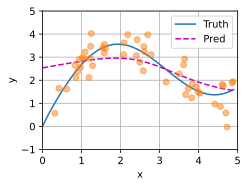

In [24]:
# 绘图对比真实值与预测值
plot_kernel_reg(y_hat)

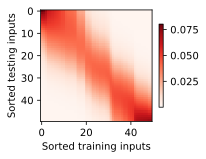

In [25]:
# 可视化注意力权重热力图
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 4. 带参数注意力汇聚

## 1. 批量矩阵乘法
- X = 张量(n, a, b)
- Y = 张量(n, b, c)
- Z = X*Y = bmm(X, Y) = (n, a, c)

In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [9]:
# Step 1: 构造数据
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))

# Step 2: 扩展维度，增加一个大小为 1 的新维度
# weights.unsqueeze(1) → shape: (2, 1, 10)
# values.unsqueeze(-1) → shape: (2, 10, 1)
# 输出 shape: (2, 1, 1)
torch.bmm(weights.unsqueeze(1),
          values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

## 2. 定义模型

In [26]:
# 这是一个 非参数回归问题 ，但通过引入一个可学习的参数 self.w，将原本固定的核函数变为可以训练的形式，从而提升模型对数据的适应能力
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # w 是一个标量参数，表示注意力核的宽度（或缩放因子）。就是那个曲线，是不是平滑
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))


    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

## 3. 训练

In [27]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [28]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

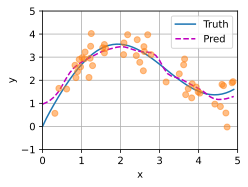

In [29]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

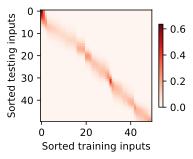

In [30]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')